#PhlyGreen Tutorial 

Import packages

In [63]:
import sys
sys.path.insert(0,'../')
import PhlyGreen as pg
import numpy as np
import matplotlib.pyplot as plt

Create instances of subsystems. Each one of those requires an Aircraft object as argument. By passing (None) as argument, we are creating empty objects (for the moment).

In [64]:
powertrain = pg.Systems.Powertrain.Powertrain(None)
structures = pg.Systems.Structures.Structures(None)
aerodynamics = pg.Systems.Aerodynamics.Aerodynamics(None)
performance = pg.Performance.Performance(None)
mission = pg.Mission.Mission(None)
weight = pg.Weight.Weight(None)
constraint = pg.Constraint.Constraint(None)
welltowake = pg.WellToWake.WellToWake(None)
climateimpact = pg.ClimateImpact.ClimateImpact(None)

Create instance of Aircraft object.

In [65]:
myaircraft = pg.Aircraft(powertrain, structures, aerodynamics, performance, mission, weight, constraint, welltowake = welltowake, climateimpact = climateimpact)

Create the connections with its subsystems.

In [66]:
powertrain.aircraft = myaircraft
structures.aircraft = myaircraft
aerodynamics.aircraft = myaircraft
mission.aircraft = myaircraft
performance.aircraft = myaircraft
weight.aircraft = myaircraft
constraint.aircraft = myaircraft
welltowake.aircraft = myaircraft
climateimpact.aircraft = myaircraft

Define input dictionaries

In [67]:
ConstraintsInput = {'DISA': 0.,
                    'Cruise': {'Speed': 0.5, 'Speed Type':'Mach', 'Beta': 0.95, 'Altitude': 8000.},
                    'AEO Climb': {'Speed': 210, 'Speed Type':'KCAS', 'Beta': 0.97, 'Altitude': 6000., 'ROC': 5},
                    'OEI Climb': {'Speed': 1.2*34.5, 'Speed Type': 'TAS', 'Beta': 1., 'Altitude': 0., 'Climb Gradient': 0.021},
                    'Take Off': {'Speed': 90, 'Speed Type': 'TAS', 'Beta': 1., 'Altitude': 100., 'kTO': 1.2, 'sTO': 950},
                    'Landing':{'Speed': 59., 'Speed Type': 'TAS', 'Altitude': 500.},
                    'Turn':{'Speed': 210, 'Speed Type': 'KCAS', 'Beta': 0.9, 'Altitude': 5000, 'Load Factor': 1.1},
                    'Ceiling':{'Speed': 0.5, 'Beta': 0.8, 'Altitude': 9500, 'HT': 0.5},
                    'Acceleration':{'Mach 1': 0.3, 'Mach 2':0.4, 'DT': 180, 'Altitude': 6000, 'Beta': 0.9}}

In [68]:
MissionInput = {'Range Mission': 750,  #nautical miles
                'Range Diversion': 220,  #nautical miles
                'Beta start': 0.97,
                'Payload Weight': 4560,  #Kg
                'Crew Weight': 500}  #Kg

In [69]:
MissionStages = {'Takeoff': {'Supplied Power Ratio':{'phi': 0.0}},
                'Climb1': {'type': 'ConstantRateClimb', 'input': {'CB': 0.16, 'Speed': 77, 'StartAltitude': 100, 'EndAltitude': 1500}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Climb2': {'type': 'ConstantRateClimb', 'input': {'CB': 0.08, 'Speed': 120, 'StartAltitude': 1500, 'EndAltitude': 4500}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Climb3': {'type': 'ConstantRateClimb', 'input': {'CB': 0.07, 'Speed': 125, 'StartAltitude': 4500, 'EndAltitude': 8000}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0. }},
                 'Cruise': {'type': 'ConstantMachCruise', 'input':{ 'Mach': 0.4, 'Altitude': 8000}, 'Supplied Power Ratio':{'phi_start': 0., 'phi_end':0.1}},
                 'Descent1': {'type': 'ConstantRateDescent', 'input':{'CB': -0.04, 'Speed': 90, 'StartAltitude': 8000, 'EndAltitude': 200}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }}}

DiversionStages = {'Climb1': {'type': 'ConstantRateClimb', 'input': {'CB': 0.08, 'Speed': 110, 'StartAltitude': 200, 'EndAltitude': 3100}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Cruise': {'type': 'ConstantMachCruise', 'input':{ 'Mach': 0.35, 'Altitude': 3100}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0}},
                 'Descent1': {'type': 'ConstantRateDescent', 'input':{'CB': -0.04, 'Speed': 90, 'StartAltitude': 3100, 'EndAltitude': 200}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }}}


In [70]:
EnergyInput = {'Ef': 43.5*10**6,
                   'Contingency Fuel': 130,
                   'Ebat': 700 * 3600,
                   'pbat': 1000,
                   'Eta Gas Turbine': 0.22,
                   'Eta Gearbox': 0.96,
                   'Eta Propulsive': 0.9,
                   'Eta Electric Motor 1': 0.96,    #for serial config
                   'Eta Electric Motor 2': 0.96,    #for serial config
                   'Eta Electric Motor': 0.98,      #for parallel config
                   'Eta PMAD': 0.99,
                   'Specific Power Powertrain': [3900,7700],
                   'Specific Power PMAD': [2200,2200,2200],
                   'PowertoWeight Battery': 35, 
                   'PowertoWeight Powertrain': [150,33],
                   'PowertoWeight PMAD': 0
                   }


WellToTankInput = {'Eta Charge': 0.95,
                   'Eta Grid': 1.,
                   'Eta Extraction': 1.,
                   'Eta Production': 1.,
                   'Eta Transportation': 0.25}

ClimateImpactInput = {'H': 100, 'N':1.6e7, 'Y':30, 'EINOx_model':'Filippone'}

In [71]:
AerodynamicsInput = {'AnalyticPolar': {'type': 'Quadratic', 'input': {'AR': 11, 'e_osw': 0.8}},
                    'Take Off Cl': 1.9,
                     'Landing Cl': 1.9,
                     'Minimum Cl': 0.20,
                     'Cd0': 0.017}


Import input dictionaries

In [72]:
myaircraft.ConstraintsInput = ConstraintsInput
myaircraft.AerodynamicsInput = AerodynamicsInput
myaircraft.MissionInput = MissionInput
myaircraft.MissionStages = MissionStages
myaircraft.DiversionStages = DiversionStages
myaircraft.EnergyInput = EnergyInput
myaircraft.WellToTankInput = WellToTankInput
myaircraft.ClimateImpactInput = ClimateImpactInput

Set aircraft power configuration

In [73]:
myaircraft.Configuration = 'Hybrid'
myaircraft.HybridType = 'Parallel'
myaircraft.AircraftType = 'ATR'

Set inputs

In [74]:
# Initialize Constraint Analysis
myaircraft.constraint.SetInput()

# Initialize Mission profile and Analysis
myaircraft.mission.InitializeProfile()
myaircraft.mission.SetInput()

# Initialize Aerodynamics subsystem
myaircraft.aerodynamics.SetInput()

# Initialize Powertrain
myaircraft.powertrain.SetInput()

# Initialize Weight Estimator
myaircraft.weight.SetInput()

#Initialized Well to Tank
myaircraft.welltowake.SetInput()

# Initialize Climate Impace Estimator
myaircraft.climateimpact.SetInput()

Either run the Constraint Analysis....

In [75]:
myaircraft.constraint.FindDesignPoint()
print('----------------------------------------')
print('Design W/S: ',myaircraft.DesignWTOoS)
print('Design P/W: ',myaircraft.DesignPW)
print('----------------------------------------')

----------------------------------------
Design W/S:  3293.8228228228227
Design P/W:  194.90567908431782
----------------------------------------


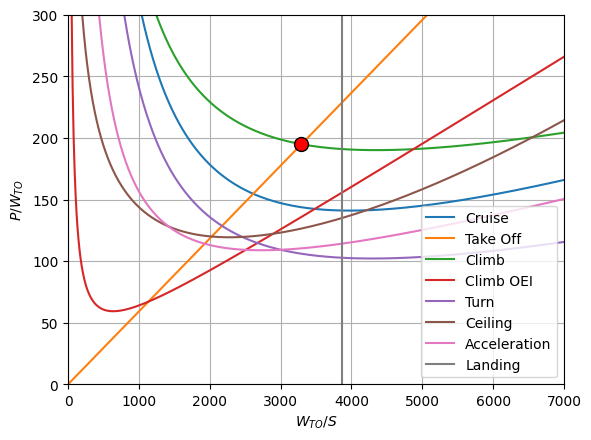

In [76]:
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWCruise, label='Cruise')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWTakeOff, label='Take Off')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWAEOClimb, label='Climb')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWOEIClimb, label='Climb OEI')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWTurn, label='Turn')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWCeiling, label='Ceiling')
plt.plot(myaircraft.constraint.WTOoS,myaircraft.constraint.PWAcceleration, label='Acceleration')
plt.plot(myaircraft.constraint.WTOoSLanding,myaircraft. constraint.PWLanding, label='Landing')
plt.plot(myaircraft.DesignWTOoS, myaircraft.DesignPW, marker='o', markersize = 10, markerfacecolor = 'red', markeredgecolor = 'black')
# plt.plot(performance.WTOoSTorenbeek, performance.PWTorenbeek, label='Torenbeek')
plt.ylim([0, 300])
plt.xlim([0, 7000])
plt.legend()
plt.grid(visible=True)
plt.xlabel('$W_{TO}/S$')
plt.ylabel('$P/W_{TO}$')
plt.show()

... or assign a wing loading

In [77]:
# myaircraft.DesignWTOoS = 3323

Run Mission analysis to define the aircraft's masses

In [78]:
myaircraft.weight.WeightEstimation()

if (myaircraft.Configuration == 'Hybrid' and WellToTankInput is not None):
    myaircraft.welltowake.EvaluateSource()

Wing surface can be readily estimated as S = WTO/(WTO/S)

In [79]:
myaircraft.WingSurface = myaircraft.weight.WTO / myaircraft.DesignWTOoS * 9.81

Calculation of the climate impact 

In [80]:
# if myaircraft.climateimpact.mission_data is None:
#     myaircraft.climateimpact.calculate_mission_data()
# np.set_printoptions(suppress=True, precision=2)
# print(myaircraft.climateimpact.mission_data)


# if myaircraft.climateimpact.frazioni_di_missione is None:
#     myaircraft.climateimpact.calculate_frazioni_di_missione()
# np.set_printoptions(suppress=True, precision=6)
# print(myaircraft.climateimpact.frazioni_di_missione)
# print(sum(myaircraft.climateimpact.frazioni_di_missione[1]))
# myaircraft.climateimpact.calculate_mission_emissions()
# print(myaircraft.climateimpact.mission_emissions)

# myaircraft.climateimpact.plot_forcing()
# print(myaircraft.climateimpact.media_pesata_quote/0.30)
# print(myaircraft.climateimpact.s_o3s(myaircraft.climateimpact.media_pesata_quote))
# print(np.interp(myaircraft.climateimpact.media_pesata_quote,myaircraft.climateimpact.Altitudes_for_forcing,myaircraft.climateimpact.s_o3s_data))

myaircraft.climateimpact.ATR()

6167.322694534672
0.002751637869271309


0.002751637869271309

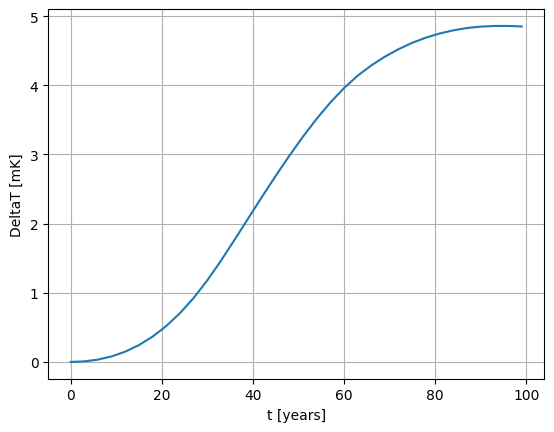

In [81]:
# years = range(0, myaircraft.climateimpact.H+1, 2)  
years = range(0, myaircraft.climateimpact.H+1, 3)  # tempo d'esecuzione: 2m 28s
# years = range(0, myaircraft.climateimpact.H+1, 4)  
DT = np.zeros(len(years))
for i in range(len(years)):
    DT[i] = myaircraft.climateimpact.DeltaT(years[i])
    
np.set_printoptions(precision=6, suppress=False)

plt.plot(years, DT*1000)
plt.grid(visible=True)
plt.xlabel('t [years]')
plt.ylabel('DeltaT [mK]')
plt.show()

A summary of the preliminary design:

In [82]:
print('Fuel mass (trip + altn) [Kg]: ', myaircraft.weight.Wf)
print('Block Fuel mass [Kg]:         ', myaircraft.weight.Wf + myaircraft.weight.final_reserve)
print('Battery mass [Kg]:            ', myaircraft.weight.WBat)
print('Structure [Kg]:               ', myaircraft.weight.WStructure)
print('Powertrain mass [Kg]:         ',myaircraft.weight.WPT)
print('Empty Weight [Kg]:            ', myaircraft.weight.WPT + myaircraft.weight.WStructure + myaircraft.weight.WCrew + myaircraft.weight.WBat)
print('Zero Fuel Weight [Kg]:        ', myaircraft.weight.WPT + myaircraft.weight.WStructure + myaircraft.weight.WCrew + myaircraft.weight.WBat + myaircraft.weight.WPayload)
print('----------------------------------------')
print('Takeoff Weight: ', myaircraft.weight.WTO)
if myaircraft.WellToTankInput is not None:
    print('Source Energy: ', myaircraft.welltowake.SourceEnergy/1.e6,' MJ')
    print('Psi: ', myaircraft.welltowake.Psi)
print('Wing Surface: ', myaircraft.WingSurface, ' m^2')
print('TakeOff engine shaft peak power [kW]:      ', myaircraft.mission.TO_PP/1000.)
print('Climb/cruise engine shaft peak power [kW]: ', myaircraft.mission.Max_PEng/1000.)
print('TakeOff battery peak power [kW]:           ', myaircraft.mission.TO_PBat/1000.)
print('Climb/cruise battery peak power [kW]:      ', myaircraft.mission.Max_PBat/1000.)
print('Sizing phase for battery: ', 'Cruise energy' if myaircraft.weight.WBatidx == 0 else 'Cruise peak power' if myaircraft.weight.WBatidx == 1 else 'Takeoff peak power'  )
print('Sizing phase for thermal powertrain ', 'Climb/Cruise peak power' if myaircraft.mission.Max_PEng > myaircraft.mission.TO_PP else 'Takeoff peak power'  )
print('Sizing phase for electric powertrain ', 'Climb/Cruise peak power' if myaircraft.mission.Max_PBat > myaircraft.mission.TO_PBat else 'Takeoff peak power'  )

Fuel mass (trip + altn) [Kg]:  1934.5971387966301
Block Fuel mass [Kg]:          2064.59713879663
Battery mass [Kg]:             918.7839960353681
Structure [Kg]:                11408.615938341662
Powertrain mass [Kg]:          1259.1894833761185
Empty Weight [Kg]:             14086.589417753148
Zero Fuel Weight [Kg]:         18646.589417753148
----------------------------------------
Takeoff Weight:  21332.485203452175
Source Energy:  339057.0975927285  MJ
Psi:  0.007188156388462933
Wing Surface:  63.534589169711005  m^2
TakeOff engine shaft peak power [kW]:       4671.727082944137
Climb/cruise engine shaft peak power [kW]:  3849.002496455876
TakeOff battery peak power [kW]:            0.0
Climb/cruise battery peak power [kW]:       472.0927300294831
Sizing phase for battery:  Cruise energy
Sizing phase for thermal powertrain  Takeoff peak power
Sizing phase for electric powertrain  Climb/Cruise peak power


Some plots:

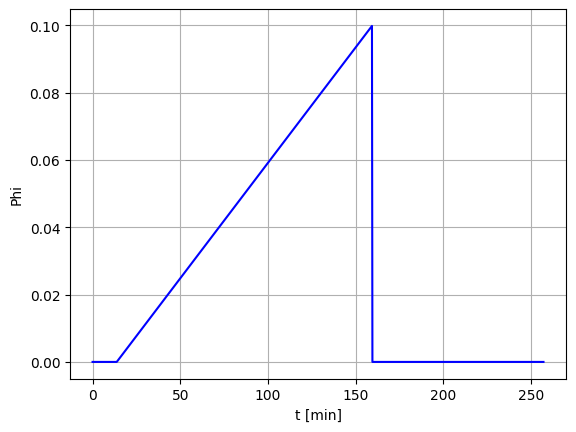

In [83]:
times = np.linspace(0,mission.profile.MissionTime2,num = 1000)
plt.plot(times/60,[mission.profile.SuppliedPowerRatio(t) for t in times], 'b')
#plt.plot(myaircraft.mission.profile.Breaks,np.ones(6)*0.05, '*')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Phi')
plt.show()

In [84]:
times = np.array([])
Ef = np.array([])
Ebat = np.array([])
beta = np.array([])
for array in mission.integral_solution:
    times = np.concatenate([times, array.t])
    Ef = np.concatenate([Ef, array.y[0]])
    Ebat = np.concatenate([Ebat, array.y[1]])
    beta = np.concatenate([beta, array.y[2]])

Takeoff propulsive power

In [85]:
myaircraft.performance.TakeOff(myaircraft.DesignWTOoS,myaircraft.constraint.TakeOffConstraints['Beta'], myaircraft.constraint.TakeOffConstraints['Altitude'],myaircraft.constraint.TakeOffConstraints['kTO'], myaircraft.constraint.TakeOffConstraints['sTO'], myaircraft.constraint.DISA, myaircraft.constraint.TakeOffConstraints['Speed'], myaircraft.constraint.TakeOffConstraints['Speed Type'])

194.88837279163596

Maximum mission Propusive Power over Takeoff Mass

In [86]:
max([myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))])

160.56713504173675

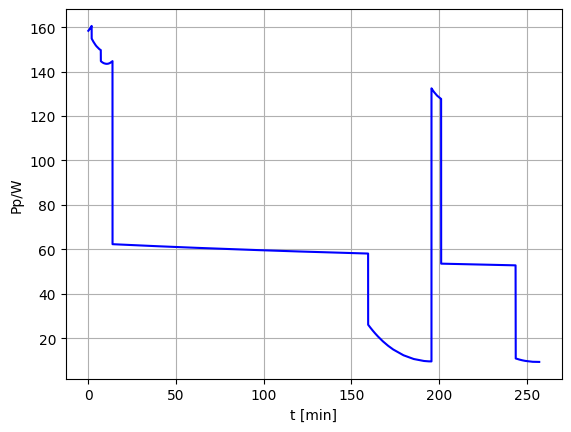

In [87]:
plt.plot(times/60,[myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))], 'b')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Pp/W')
plt.show()

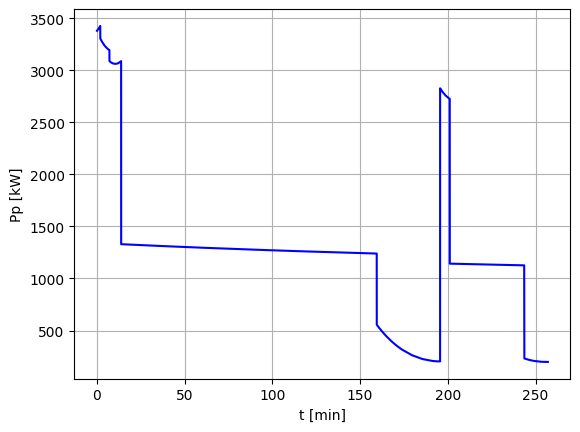

In [88]:
plt.plot(times/60,[(myaircraft.weight.WTO/1000) * myaircraft.performance.PoWTO(myaircraft.DesignWTOoS,beta[t],myaircraft.mission.profile.PowerExcess(times[t]),1,myaircraft.mission.profile.Altitude(times[t]),myaircraft.mission.DISA,myaircraft.mission.profile.Velocity(times[t]),'TAS') for t in range(len(times))], 'b')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Pp [kW]')
plt.show()

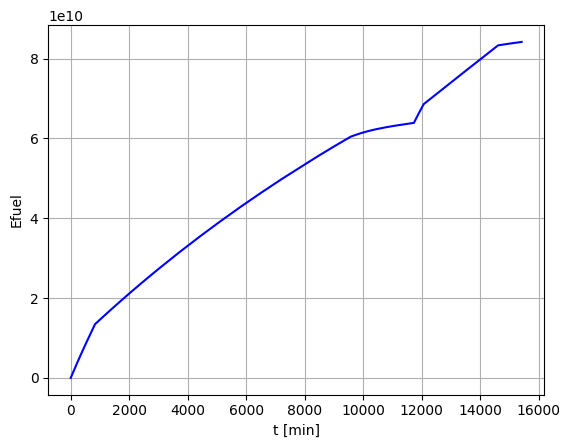

In [89]:
plt.plot(times,Ef, 'b')
#plt.plot(myaircraft.mission.profile.Breaks,np.ones(6)*0.05, '*')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Efuel')
plt.show()

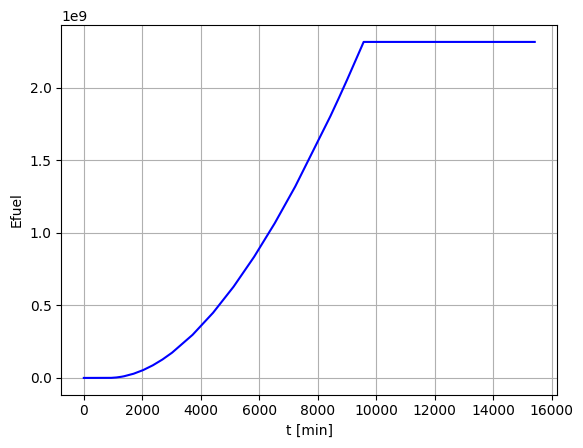

In [90]:
plt.plot(times,Ebat, 'b')
#plt.plot(myaircraft.mission.profile.Breaks,np.ones(6)*0.05, '*')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Efuel')
plt.show()

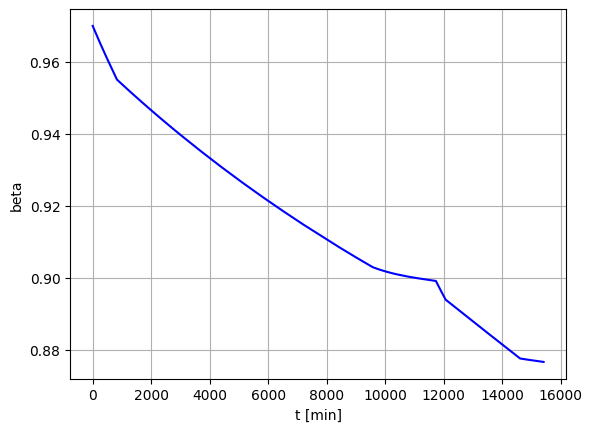

In [91]:
plt.plot(times,beta, 'b')
#plt.plot(myaircraft.mission.profile.Breaks,np.ones(6)*0.05, '*')
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('beta')
plt.show()

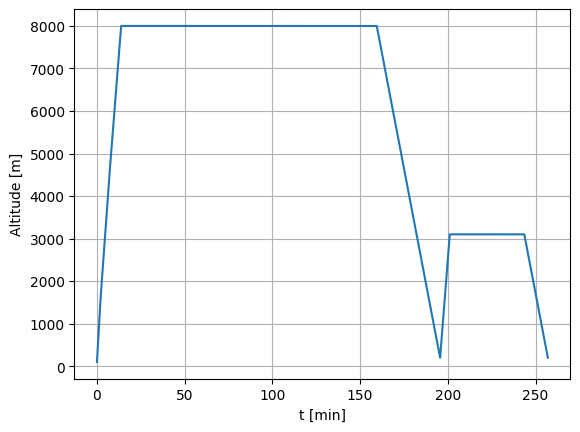

In [92]:
plt.plot(times/60,mission.profile.Altitude(times))
plt.grid(visible=True)
plt.xlabel('t [min]')
plt.ylabel('Altitude [m]')
plt.show()

alt = mission.profile.Altitude(times) 
vel = mission.profile.Velocity(times)


In [93]:

# # Creating subsystem instances
# powertrain = pg.Systems.Powertrain.Powertrain(None)
# structures = pg.Systems.Structures.Structures(None)
# aerodynamics = pg.Systems.Aerodynamics.Aerodynamics(None)
# performance = pg.Performance.Performance(None)
# mission = pg.Mission.Mission(None)
# weight = pg.Weight.Weight(None)
# constraint = pg.Constraint.Constraint(None)
# welltowake = pg.WellToWake.WellToWake(None)


# # # Creating mediator and associating with subsystems
# myaircraft = pg.Aircraft(powertrain, structures, aerodynamics, performance, mission, weight, constraint, welltowake)



# # # Associating subsystems with the mediator
# powertrain.aircraft = myaircraft
# structures.aircraft = myaircraft
# aerodynamics.aircraft = myaircraft
# mission.aircraft = myaircraft
# performance.aircraft = myaircraft
# weight.aircraft = myaircraft
# constraint.aircraft = myaircraft
# welltowake.aircraft = myaircraft

# MissionStages = {'Takeoff': {'Supplied Power Ratio':{'phi': 0.05}},
#                 'Climb1': {'type': 'OptimumClimb', 'input': {'CB': 0.16, 'Speed': 77, 'StartAltitude': 100, 'EndAltitude': 1500}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
#                  'Climb2': {'type': 'OptimumClimb', 'input': {'CB': 0.08, 'Speed': 120, 'StartAltitude': 1500, 'EndAltitude': 4500}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
#                  'Climb3': {'type': 'OptimumClimb', 'input': {'CB': 0.07, 'Speed': 125, 'StartAltitude': 4500, 'EndAltitude': 8000}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
#                  'Cruise': {'type': 'DiscretizedCruise', 'input':{ 'Mach': 0.4, 'Altitude': 8000}, 'Supplied Power Ratio':{'phi_start': 0., 'phi_end':0.2 }},
#                  'Descent1': {'type': 'OptimumDescent', 'input':{'CB': -0.04, 'Speed': 90, 'StartAltitude': 8000, 'EndAltitude': 200}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }}}

# DiversionStages = {'Climb1': {'type': 'OptimumClimb', 'input': {'CB': 0.08, 'Speed': 110, 'StartAltitude': 200, 'EndAltitude': 3100}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
#                  'Cruise': {'type': 'DiscretizedCruise', 'input':{ 'Mach': 0.35, 'Altitude': 3100}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0}},
#                  'Descent1': {'type': 'OptimumDescent', 'input':{'CB': -0.04, 'Speed': 90, 'StartAltitude': 3100, 'EndAltitude': 200}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }}}




# #myaircraft.Configuration = 'Traditional'
# myaircraft.Configuration = 'Hybrid'
# myaircraft.HybridType = 'Parallel'
# myaircraft.AircraftType = 'ATR'
# myaircraft.MissionType = 'Discrete'

# myaircraft.DesignAircraft(AerodynamicsInput,ConstraintsInput,MissionInput,EnergyInput,MissionStages,DiversionStages, WellToTankInput=WellToTankInput,PrintOutput=True)




# # plt.plot(myaircraft.mission.profile.DiscretizedTime,[myaircraft.mission.profile.SuppliedPowerRatio(t) for t in myaircraft.mission.profile.DiscretizedTime])
# # plt.show()

# # plt.plot(myaircraft.mission.profile.DiscretizedTime, myaircraft.mission.EBat_values)
# # plt.show()

# plt.plot(myaircraft.mission.profile.DiscretizedTime/60, myaircraft.mission.EF_values, label='Discrete')
# plt.plot(times/60, Ef, label = 'Continue')
# # plt.plot(myaircraft.mission.profile.Breaks, 7e10*np.ones(len(myaircraft.mission.profile.Breaks)), marker='o', markersize = 10, markerfacecolor = 'red', markeredgecolor = 'black')
# plt.legend()
# plt.grid(visible=True)
# plt.show()

# plt.plot(myaircraft.mission.profile.DiscretizedTime/60, myaircraft.mission.EBat_values, label='Discrete')
# plt.plot(times/60, Ebat, label = 'Continue')
# # plt.plot(myaircraft.mission.profile.Breaks, 7e10*np.ones(len(myaircraft.mission.profile.Breaks)), marker='o', markersize = 10, markerfacecolor = 'red', markeredgecolor = 'black')
# plt.legend()
# plt.grid(visible=True)
# plt.show()

# plt.plot(myaircraft.mission.profile.DiscretizedTime/60,myaircraft.mission.profile.DiscretizedAltitudes, label = 'Discrete')
# plt.plot(times/60,alt, label = 'Continue')
# # plt.plot(myaircraft.mission.profile.DiscretizedTime/60,[myaircraft.mission.profile.SuppliedPowerRatio(t)*10000 for t in myaircraft.mission.profile.DiscretizedTime])
# # plt.plot(myaircraft.mission.profile.Breaks, 2000*np.ones(len(myaircraft.mission.profile.Breaks)), marker='o', markersize = 10, markerfacecolor = 'red', markeredgecolor = 'black')
# plt.grid(visible=True)
# plt.xlabel('t [min]')
# plt.ylabel('Altitude [m]')
# plt.legend()
# plt.show()

# plt.plot(myaircraft.mission.profile.DiscretizedTime/60,myaircraft.mission.profile.DiscretizedVelocities, label = 'Discrete')
# plt.plot(times/60, vel, label = 'Continue')
# plt.grid(visible=True)
# plt.xlabel('t [min]')
# plt.ylabel('Velocity [m/s]')
# plt.legend()
# plt.show()


# # plt.plot(myaircraft.mission.profile.DiscretizedTime/60,[myaircraft.mission.profile.SuppliedPowerRatio(t) for t in myaircraft.mission.profile.DiscretizedTime])
# # plt.grid(visible=True)
# # plt.xlabel('t [min]')
# # plt.ylabel('Velocity [m/s]')
# # plt.show()

# # print(myaircraft.mission.profile.DiscretizedTime)
# # print([myaircraft.mission.profile.SuppliedPowerRatio(t) for t in myaircraft.mission.profile.DiscretizedTime])
# # print(myaircraft.mission.profile.SuppliedPowerRatio(myaircraft.mission.profile.times[-1]))